# LSTM Model to Predict SPY Next Day Log Returns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Load and Preprocess Data

In [2]:
data = pd.read_csv('LSTM_SPY_21_Nov.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

data = data.iloc[:].dropna()
print(f"Data loaded. Shape: {data.shape}")

# Define features
features = [
    'Close',
    'High',
    'Low',
    'Open',

    # trend
    'DIF',
    'MACD',
    'Efficiency_Ratio_20D',

    # momentum and oscillator
    'RSI_6',
    'RSI_12',
    'RSI_24',
    'Overbought',
    'Oversold',

    # volatility and market structure
    'Volume',
    'Volatility_20D',
    'Pos_in_BBand',
    'Log_Hi_Lo_Ratio',
    
    # recent performance
    'Log_Return',
    'Log_Return_Intra-day',
    'Log_Return_5D'
]

# Split the data into training and testing sets based on a specific date
split_date = '2022-01-03'  
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]

# Scale the features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data[features].values)
X_test = scaler.transform(test_data[features].values)

# Extract the target variable for training and testing
y_train = train_data['Next_Day_Log_Return'].values
y_test = test_data['Next_Day_Log_Return'].values

# Create DataFrames to display X and y
X_y_train_df = pd.DataFrame(X_train, columns=features)
X_y_train_df['Next_Day_Log_Return'] = y_train

X_y_test_df = pd.DataFrame(X_test, columns=features)
X_y_test_df['Next_Day_Log_Return'] = y_test

print(f"Training Features (X_train) shape: {X_train.shape}")
print(f"Testing Features (X_test) shape: {X_test.shape}")
print(f"Training Target (y_train) shape: {y_train.shape}")
print(f"Testing Target (y_test) shape: {y_test.shape}")

Data loaded. Shape: (2590, 42)
Training Features (X_train) shape: (1714, 19)
Testing Features (X_test) shape: (876, 19)
Training Target (y_train) shape: (1714,)
Testing Target (y_test) shape: (876,)


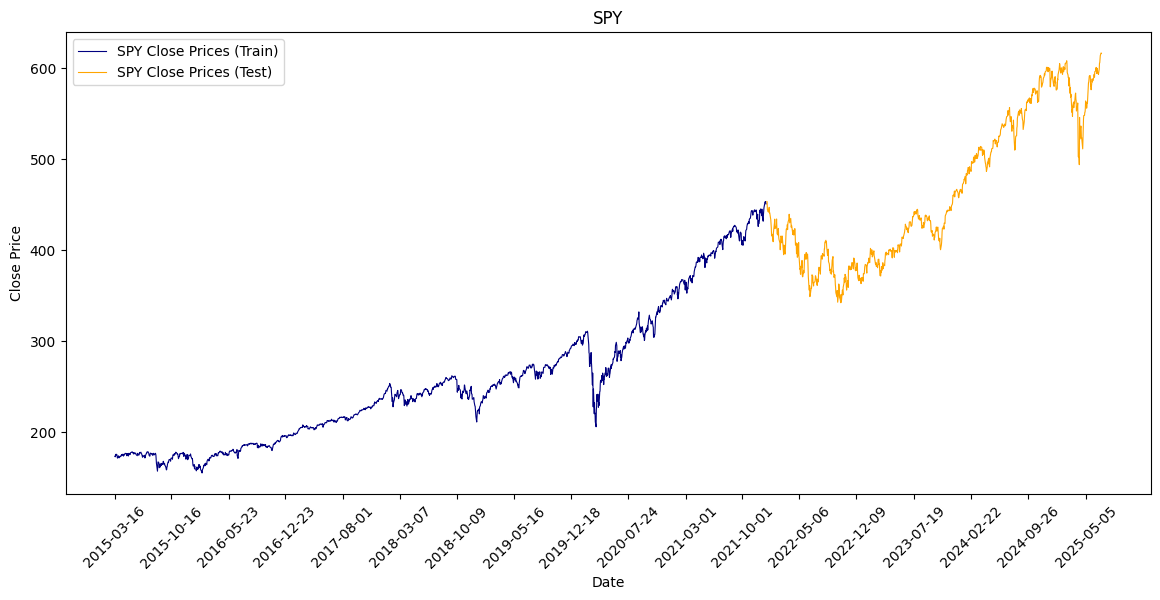

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(data['Date'][:len(train_data)], data['Close'][:len(train_data)], label='SPY Close Prices (Train)', color='navy', linewidth=0.8)
plt.plot(data['Date'][len(train_data):], data['Close'][len(train_data):], label='SPY Close Prices (Test)', color='orange', linewidth=0.8)
plt.title('SPY')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(ticks=data['Date'][::150], rotation=45) 
plt.show()

## Create Sequences for LSTM

In [4]:
sequence_length = 9

# Create sequences for training data
X_train_sequences, y_train_sequences = [], []
for i in range(len(X_train) - sequence_length):
    X_train_sequences.append(X_train[i:i + sequence_length])
    y_train_sequences.append(y_train[i + sequence_length])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)

# Create sequences for testing data
X_test_sequences, y_test_sequences = [], []
for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test_sequences.append(y_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)

print(f"Training Sequences Shape: {X_train_sequences.shape}")
print(f"Testing Sequences Shape: {X_test_sequences.shape}")

Training Sequences Shape: (1705, 9, 19)
Testing Sequences Shape: (867, 9, 19)


## Build LSTM Model

In [5]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])),
    Dropout(0),
    LSTM(128, return_sequences=True),
    Dropout(0),
    LSTM(32, return_sequences=False),
    Dense(1)
])

# Define a custom metric to penalize conservative predictions
def boldness_adjusted_mse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mean_penalty = tf.reduce_mean(tf.square(y_pred - tf.reduce_mean(y_true)))
    return mse + 1 * mean_penalty 

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[boldness_adjusted_mse])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model

In [6]:
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    return [early_stopping, lr_scheduler, checkpoint]

callbacks = get_callbacks()

history = model.fit(
    X_train_sequences, y_train_sequences,
    epochs=50,
    batch_size=4,
    validation_data=(X_test_sequences, y_test_sequences),
    callbacks=callbacks,
    verbose=0
)

## Training History

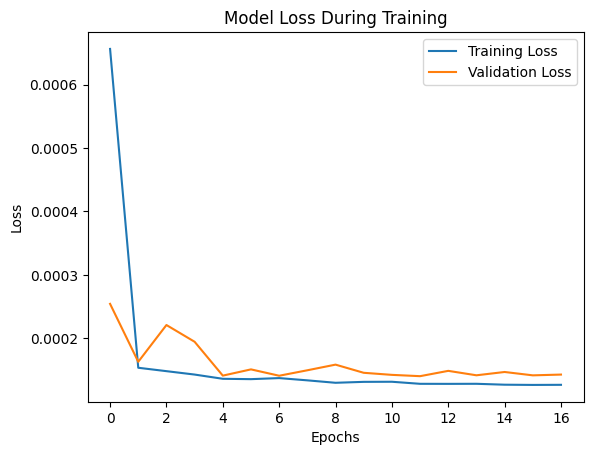

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate Model

Test Loss: [0.00014046415162738413, 0.00014219875447452068]
Test MSE: 0.00014046413964338318


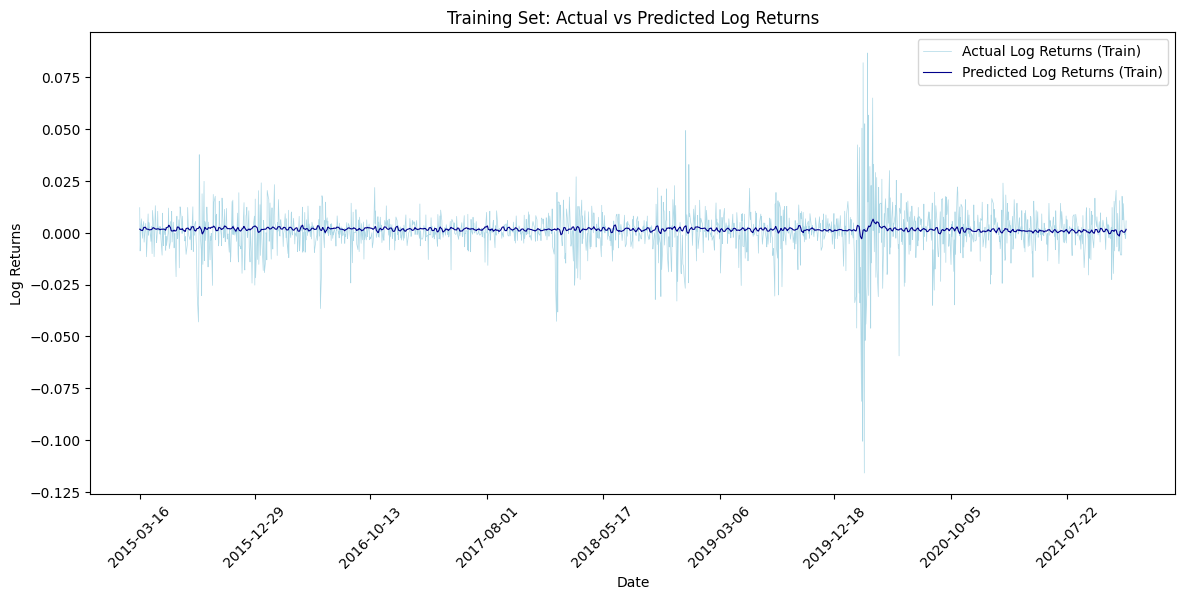

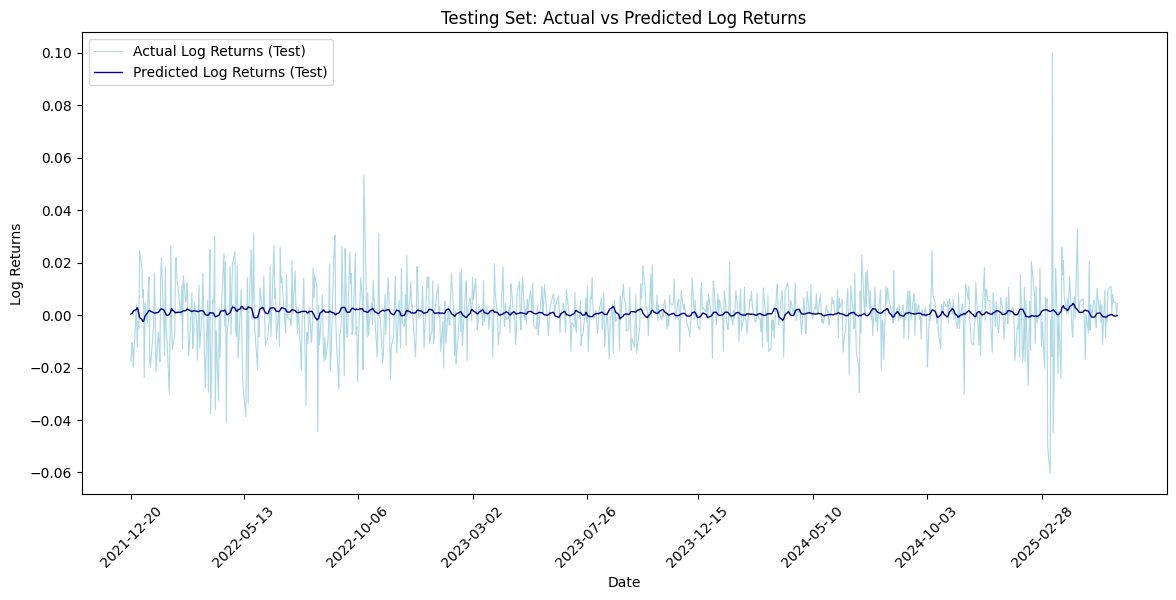

In [8]:
loss = model.evaluate(X_test_sequences, y_test_sequences, verbose=0)
print(f'Test Loss: {loss}')

# Calculate MSE for predictions
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test_sequences, verbose=0)
train_predictions = model.predict(X_train_sequences, verbose=0)
mse = mean_squared_error(y_test_sequences, predictions)
print(f'Test MSE: {mse}')

# Plot actual vs predicted log returns for the training set
plt.figure(figsize=(14, 6))
plt.plot(data['Date'].values[:len(y_train_sequences)], y_train_sequences, label='Actual Log Returns (Train)', color='lightblue', alpha=1, linewidth=0.5)
plt.plot(data['Date'].values[:len(y_train_sequences)], train_predictions.flatten(), label='Predicted Log Returns (Train)', color='darkblue', alpha=1, linewidth=0.8)
plt.title('Training Set: Actual vs Predicted Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.xticks(ticks=data['Date'].values[:len(y_train_sequences):200], rotation=45) 
plt.show()

# Plot actual vs predicted log returns for the testing set
plt.figure(figsize=(14, 6))
plt.plot(data['Date'].values[len(y_train_sequences):len(y_train_sequences) + len(y_test_sequences)], y_test_sequences, label='Actual Log Returns (Test)', color='lightblue', alpha=1, linewidth=0.8)
plt.plot(data['Date'].values[len(y_train_sequences):len(y_train_sequences) + len(y_test_sequences)], predictions.flatten(), label='Predicted Log Returns (Test)', color='darkblue', alpha=1, linewidth=1)
plt.title('Testing Set: Actual vs Predicted Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.xticks(ticks=data['Date'].values[len(y_train_sequences)::100], rotation=45) 
plt.show()

## Convert Predicted Return to Price 

MSE of Predicted Next Day Close: 27.950152102184695


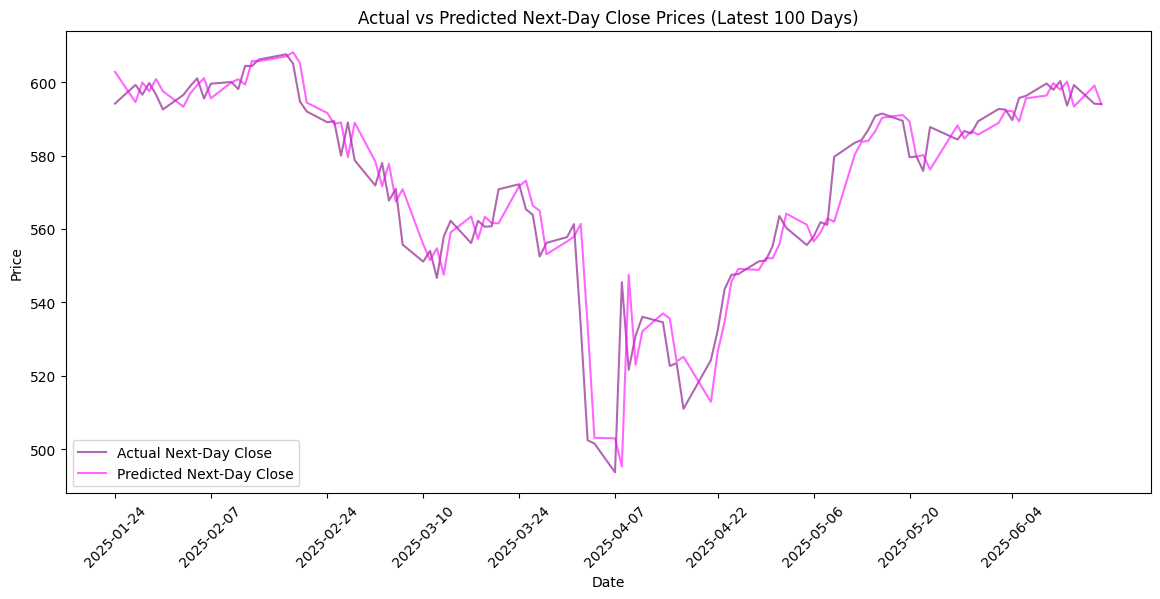

,Date,Close,Next_Day_Close,Predicted_Log_Return,Predicted_Next_Day_Close
0,2022-01-03,453.210,453.059,0.000378,453.381535
1,2022-01-04,453.059,444.359,0.000621,453.340332
2,2022-01-05,444.359,443.941,0.000886,444.752739
3,2022-01-06,443.941,442.186,0.001558,444.633060
4,2022-01-07,442.186,441.636,0.002145,443.135724
...,...,...,...,...,...
862,2025-06-11,597.930,600.306,0.000003,597.932067
863,2025-06-12,600.306,593.595,-0.000263,600.148349
864,2025-06-13,593.595,599.242,-0.000410,593.351897
865,2025-06-16,599.242,594.122,-0.000259,599.086807


In [9]:
results_df = pd.DataFrame({
    'Date': data['Date'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Close': data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Next_Day_Close': data['Next_Day_Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Predicted_Log_Return': predictions.flatten(),
    'Predicted_Next_Day_Close': data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)] * np.exp(predictions.flatten())
})

# Calculate MSE for Predicted Next Day Close and Actual Next Day Close
mse_ndc = mean_squared_error(results_df['Next_Day_Close'], results_df['Predicted_Next_Day_Close'])
print(f'MSE of Predicted Next Day Close: {mse_ndc}')

# Plot actual vs predicted next-day close prices for the test period
plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'][-100:], results_df['Next_Day_Close'][-100:], label='Actual Next-Day Close', color='purple', alpha=0.6)
plt.plot(results_df['Date'][-100:], results_df['Predicted_Next_Day_Close'][-100:], label='Predicted Next-Day Close', color='magenta', alpha=0.6)
plt.title('Actual vs Predicted Next-Day Close Prices (Latest 100 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(ticks=results_df['Date'][-100::10], rotation=45)  
plt.show()

results_df

## Test Direction Accuracy
Multiply predicted log returns with `n` \
When n > 1 and MSE decreases -> prediction direction is accurate 

Optimal n: 1.93, Lowest MSE: 27.662238091104854


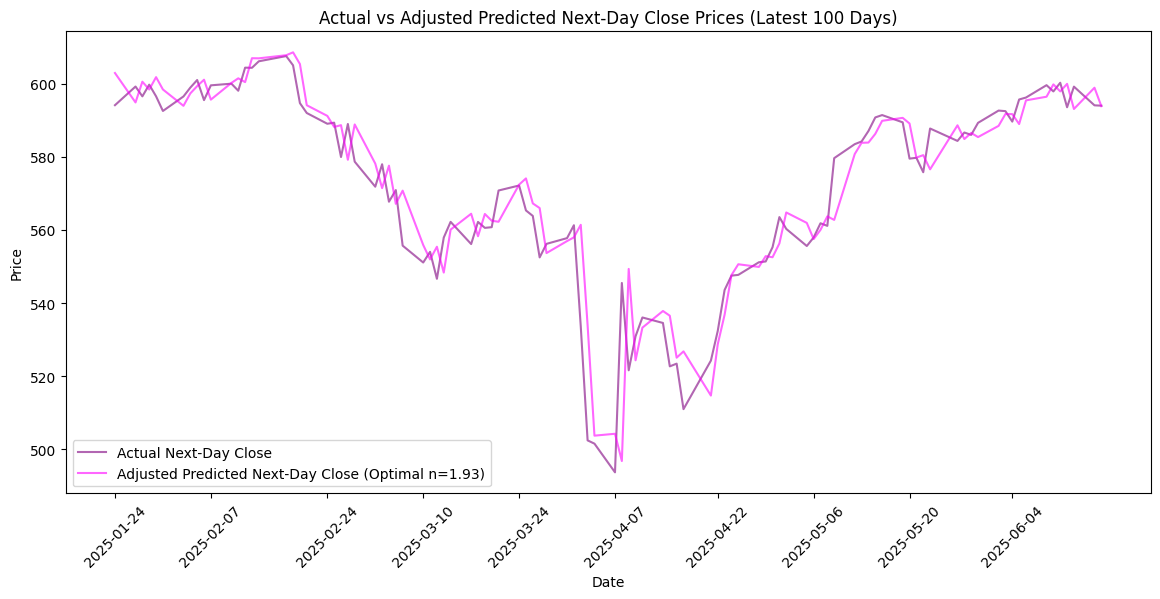

In [ ]:
# Find the optimal n using a naive loop
best_n = None
lowest_mse = float('inf')

for n in np.arange(0, 2, 0.01): 
    adjusted_predicted_log_return = n * predictions.flatten()
    adjusted_predicted_next_day_close = data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)] * np.exp(adjusted_predicted_log_return)

    mse = mean_squared_error(data['Next_Day_Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)], adjusted_predicted_next_day_close)

    if mse < lowest_mse:
        lowest_mse = mse
        best_n = n

print(f'Optimal n: {best_n}, Lowest MSE: {lowest_mse}')

# Recalculate adjusted predictions using the optimal n
adjusted_results_df = pd.DataFrame({
    'Date': data['Date'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Close': data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Next_Day_Close': data['Next_Day_Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)],
    'Predicted_Log_Return': predictions.flatten(),
    'Predicted_Next_Day_Close': data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)] * np.exp(predictions.flatten()),
    'Adjusted_Predicted_Log_Return': best_n * predictions.flatten(),
    'Adjusted_Predicted_Next_Day_Close': data['Close'].values[sequence_length + len(y_train_sequences):sequence_length + len(y_train_sequences) + len(y_test_sequences)] * np.exp(best_n * predictions.flatten())
})

# Plot the latest 100 data points for actual vs adjusted predicted next-day close prices
plt.figure(figsize=(14, 6))
plt.plot(adjusted_results_df['Date'][-100:], adjusted_results_df['Next_Day_Close'][-100:], label='Actual Next-Day Close', color='purple', alpha=0.6)
plt.plot(adjusted_results_df['Date'][-100:], adjusted_results_df['Adjusted_Predicted_Next_Day_Close'][-100:], label=f'Adjusted Predicted Next-Day Close (Optimal n={best_n})', color='magenta', alpha=0.6)
plt.title('Actual vs Adjusted Predicted Next-Day Close Prices (Latest 100 Days)')
plt.xlabel('Date')
plt.ylabel('Price') 
plt.legend()
plt.xticks(ticks=adjusted_results_df['Date'][-100::10], rotation=45)
plt.show()